In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
sns.set()

def bar_annotation(ax, option='number'):
    '''
    This function is to add according number or percentage on every bar
    option: number or percentage, default is number
    ax: the figure object
    '''
    try:
        if option == 'number':
            for i in ax.patches:
                ax.text(i.get_x(), i.get_height()+.5, i.get_height(),
                         fontsize=15, color='dimgrey')
        if option == 'percentage':
            totals = []
            for i in ax.patches:
                totals.append(i.get_height())
                total = sum(totals)
            for i in ax.patches:
                ax.text(i.get_x(), i.get_height()+.5,
                        str(round((i.get_height()/total)*100, 2))+'%',
                        fontsize=15, color='dimgrey')
    except:
        return('inputs are wrong')


def total_hours(time):
    '''
    Convert the resolution of time to hours
    '''
    return time.total_seconds()/3600


# -----------------------------------------------------------------------------------
# 1. Load the patient level table
# -----------------------------------------------------------------------------------
root_dir = 'C:/Users/gzhu1/Desktop/SAH_data'
patient = pd.read_csv(
        root_dir+"/patient_encounter/Pat_file_ENC.csv")
patient['PATIENT_SK'].nunique()                      # 4810
SAH_ENC_screened_24h_rule = pd.read_csv(
  root_dir+"/patient_encounter/SAH_ENC_screened_24h_rule.csv")
SAH_ENC_screened_24h_rule['PATIENT_SK'].nunique()    # 4810
SAH_ENC_screened_24h_rule['ENCOUNTER_ID'].nunique()  # 4823
SAH_ENC_screened_24h_rule.shape
# Get a new patient level table by adding information such as encounter ID
pat_enc_final = pd.merge(patient, SAH_ENC_screened_24h_rule, on='PATIENT_SK')
pat_enc_final.shape

# -----------------------------------------------------------------------------------
# 2. Prepare the medication table
# -----------------------------------------------------------------------------------
pd.options.display.max_rows = 50
pd.options.display.max_columns = 10
enc_med_cl2 = pd.read_csv(root_dir+'/medication/sah_pts_enc_med_sl_ad_cl2_gz.tsv',
                          delimiter='\t')
enc_med_cl3 = pd.read_csv(root_dir+'/medication/sah_pts_all_enc_med_cl3_v2.tsv',
                          delimiter='\t')
# In order to get the dose quantity,
# we need to merge some columns between enc_med_cl2 and enc_med_cl3
enc_med_cl2 = pd.merge(enc_med_cl2, enc_med_cl3[['INDEX_ID', 'DOSE_QUANTITY',
                       'ORDER_NO', 'TOTAL_DISPENSED_DOSES', 'CREDIT_QUANTITY',
                       'CHARGE_QUANTITY', 'INFUSION_TIME',
                       'DOSE_FORM_DESCRIPTION', 'ROUTE_DESCRIPTION',
                       'INITIAL_DOSE_QUANTITY']],
                        on='INDEX_ID')

enc_med_cl2['MED_STARTED_DT_TM'] = pd.to_datetime(
        enc_med_cl2['MED_STARTED_DT_TM'])
start_tm_na_ind = (enc_med_cl2['MED_STARTED_DT_TM'].apply(str)
                   == '01-JAN-1000 00:00:00')
stop_tm_na_ind = (enc_med_cl2['MED_STOPPED_DT_TM'].apply(str)
                  == '01-JAN-1000 00:00:00')
enc_med_cl2['MED_STOPPED_DT_TM'][stop_tm_na_ind] = np.nan
enc_med_cl2['MED_STOPPED_DT_TM'] = pd.to_datetime(
        enc_med_cl2['MED_STOPPED_DT_TM'])
enc_med_cl2['stop_start_gap'] = enc_med_cl2['MED_STOPPED_DT_TM'] -\
                 enc_med_cl2['MED_STARTED_DT_TM']
enc_med_cl2['stop_start_gap'] = enc_med_cl2['stop_start_gap'].\
                                apply(total_hours)
discon_tm_na_ind = (enc_med_cl2['MED_DISCONTINUED_DT_TM'].apply(str)
                  == '01-JAN-1000 00:00:00')
sum(discon_tm_na_ind)
enc_med_cl2['MED_DISCONTINUED_DT_TM'][discon_tm_na_ind] = np.nan
enc_med_cl2['MED_DISCONTINUED_DT_TM'] = pd.to_datetime(
        enc_med_cl2['MED_DISCONTINUED_DT_TM'])
# Load NDC codes
vasopressor_ndc_codes = pd.read_csv(
        root_dir+'/medication/list of vasopressors with ndc codes.tsv',
        delimiter='\t')
vasopressor_ndc_codes = vasopressor_ndc_codes[[
        'MEDICATION_ID', 'NDC_CODE']].drop_duplicates()
vasopressor_ndc_codes['MEDICATION_ID'].nunique()
vasopressor_ndc_codes['NDC_CODE'].nunique()
enc_med_cl2 = pd.merge(vasopressor_ndc_codes, enc_med_cl2, on='MEDICATION_ID',
                       how='inner')

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
# -----------------------------------------------------------------------------------
# 3. Combine the medication table with patient level table
# -----------------------------------------------------------------------------------

pat_enc_med = pd.merge(pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                       enc_med_cl2, on='ENCOUNTER_ID')
pat_enc_med['MED_STARTED_DT_TM'] = pd.to_datetime(
                                   pat_enc_med['MED_STARTED_DT_TM'])
pat_enc_med = pat_enc_med.sort_values(by='MED_STARTED_DT_TM')
group_by_patientsk = pat_enc_med.groupby('PATIENT_SK')

# Get the number of types of treatments one patient received
treatment_types_per_patient = group_by_patientsk['GENERIC_NAME'].nunique()

# -----------------------------------------------------------------------------
# 4. Get the medication table only containing the first vaospressor
# -----------------------------------------------------------------------------

pat_enc_med_grpby_pat = pat_enc_med.groupby('PATIENT_SK')
pat_firsttreat = pat_enc_med_grpby_pat.first().reset_index(drop=False)


In [3]:
# ---------------------------------------------------------------------------------
# Joint analysis of Diastolic and Systalic blood pressure and vasopressor 
# -------------------------------------------------------------------------------
Diastolic_BP = pd.read_csv(root_dir+'/vital_sign/Diastolic_BP.csv')
Diastolic_BP = Diastolic_BP.drop('PATIENT_ID', 1)
Diastolic_BP['EVENT_DATE'] = pd.to_datetime(Diastolic_BP['EVENT_DATE'])
# Merge the Diastolic_BP with patient level table
Diastolic_BP = pd.merge(Diastolic_BP,
                        pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                        how='inner', on='ENCOUNTER_ID')
# Group the Diastolic_BP by patient_sk
Diastolic_BP = Diastolic_BP.sort_values(by=['PATIENT_SK', 'EVENT_DATE'])
uniq_pat_sk= pat_firsttreat['PATIENT_SK'].unique()
valid_pat_sk_indc = np.in1d(
        uniq_pat_sk, Diastolic_BP['PATIENT_SK'].unique())
# Get the patient_sk with blood pressure
valid_pat_sk1 = uniq_pat_sk[valid_pat_sk_indc]
valid_pat_sk1.shape[0]

Systolic_BP = pd.read_csv(root_dir+'/vital_sign/Systolic_BP.csv')
Systolic_BP = Systolic_BP.drop('PATIENT_ID', 1)
Systolic_BP['EVENT_DATE'] = pd.to_datetime(Systolic_BP['EVENT_DATE'])
# Merge the Diastolic_BP with patient level table
Systolic_BP = pd.merge(Systolic_BP,
                       pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                       how='inner', on='ENCOUNTER_ID')
# Group the Systolic_BP by patient_sk
Systolic_BP = Systolic_BP.sort_values(by=['PATIENT_SK', 'EVENT_DATE'])
valid_pat_sk_indc2 = np.in1d(
        uniq_pat_sk, Systolic_BP['PATIENT_SK'].unique())
valid_pat_sk2 = uniq_pat_sk[valid_pat_sk_indc]
valid_pat_sk2.shape[0]


2390

In [4]:
# Next we want to filter out those orders without blood pressure measurements
# during the period between started time and stopped time
valid_med_df =[]
# vaso_window is the time period after order started time we are interested in
vaso_window = 2
bp_t0_window = 1
# Obervation number required within the bp_t0-vaso_start and bp_te-bp_te
obs_num_threshold = 1  
for patient_sk in valid_pat_sk1:
    patient_diasbp = Diastolic_BP[Diastolic_BP['PATIENT_SK'] == patient_sk]
    patient_sysbp = Systolic_BP[Systolic_BP['PATIENT_SK'] == patient_sk]
    patient_med = pat_firsttreat[pat_firsttreat['PATIENT_SK'] == patient_sk] 
    # Convert the time as the time difference, which originats at med_start time
    patient_diasbp_time = patient_diasbp['EVENT_DATE'] - patient_med[
            'MED_STARTED_DT_TM'].iloc[0]
    patient_sysbp_time = patient_sysbp['EVENT_DATE'] - patient_med[
            'MED_STARTED_DT_TM'].iloc[0]
    vaso_start = patient_med['MED_STARTED_DT_TM'] - patient_med[
            'MED_STARTED_DT_TM'].iloc[0]
    # Convert the resolution of time from second to hour
    patient_diasbp_time = patient_diasbp_time.apply(total_hours)
    patient_sysbp_time = patient_sysbp_time.apply(total_hours)
    vaso_start = vaso_start.apply(total_hours)
    # vaso over is the end point of the time window we are interested in
    bp_te = vaso_start+vaso_window                 
    # the period from bp_t0 to order started time
    bp_t0_2_vaso_start = [vaso_start.iloc[0]-bp_t0_window,
                                vaso_start.iloc[0]]
    diastime_within_bp_t0_2_vaso_start_inc = pd.cut(patient_diasbp_time,
                                                    bp_t0_2_vaso_start)
    diastime_within_bp_t0_2_vaso_start = patient_diasbp_time[
            diastime_within_bp_t0_2_vaso_start_inc.notnull()]
    diasbp_within_bp_t0_2_vaso_start = patient_diasbp[
            diastime_within_bp_t0_2_vaso_start_inc.notnull()]['RESULT_VALUE_NUM']
    obs_num = diasbp_within_bp_t0_2_vaso_start.shape[0]
    valid_obs_num_inc1 = obs_num > obs_num_threshold
    
    # the period from order started time to bp_over
    vaso_start_2_bp_te = [vaso_start.iloc[0], bp_te.iloc[0]]
    diastime_within_vaso_start_2_bp_te_inc = pd.cut(patient_diasbp_time,
                                                    vaso_start_2_bp_te)
    diastime_within_vaso_start_2_bp_te = patient_diasbp_time[
            diastime_within_vaso_start_2_bp_te_inc.notnull()]
    diasbp_within_vaso_start_2_bp_te = patient_diasbp[
            diastime_within_vaso_start_2_bp_te_inc.notnull()]['RESULT_VALUE_NUM']
    obs_num = diasbp_within_vaso_start_2_bp_te.shape[0]
    valid_obs_num_inc2 = obs_num > obs_num_threshold
    
    valid_order_inc = (valid_obs_num_inc1 & valid_obs_num_inc2)
    valid_med_df.append(patient_med[[valid_order_inc]])

valid_med_df = pd.concat(valid_med_df)
valid_med_df['PATIENT_SK'].nunique()
valid_pat_sk = valid_med_df['PATIENT_SK'].unique()
valid_med_df['GENERIC_NAME'].value_counts()


phenylephrine     417
norepinephrine    230
dopamine           94
Name: GENERIC_NAME, dtype: int64

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

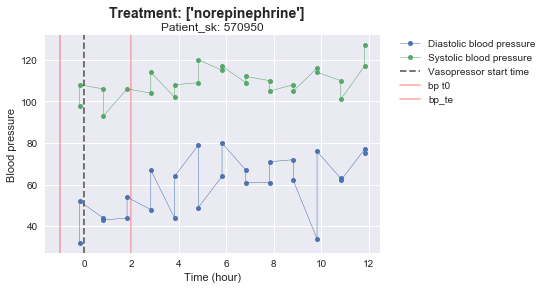

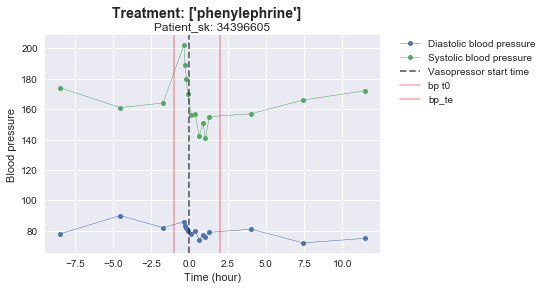

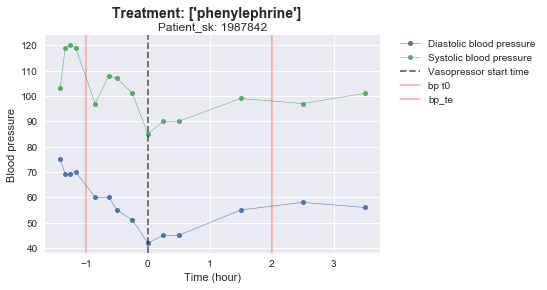

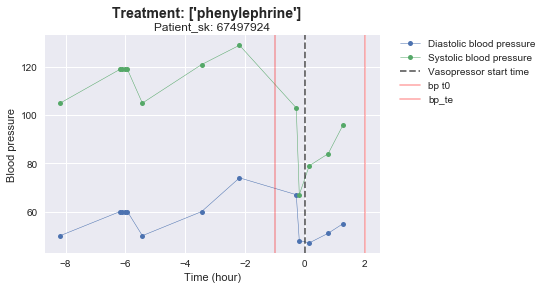

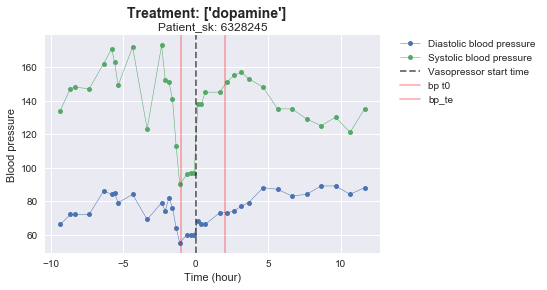

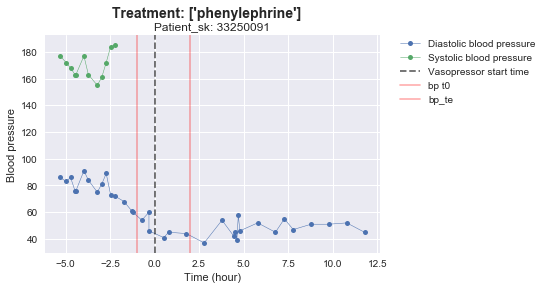

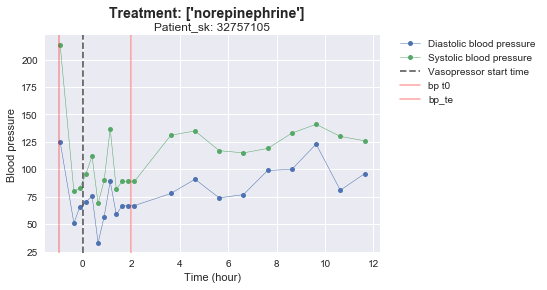

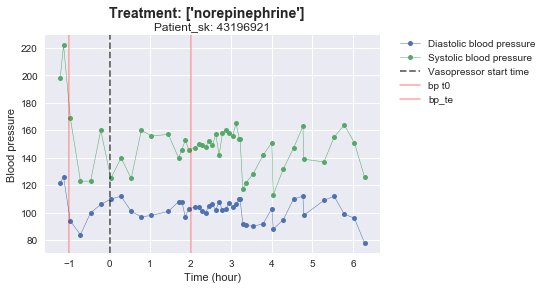

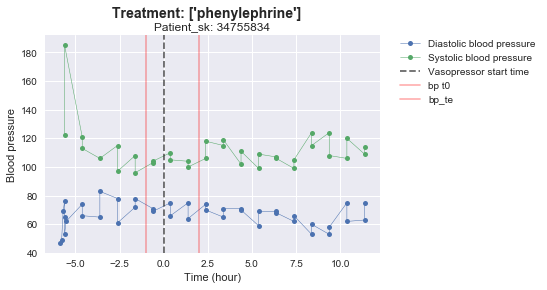

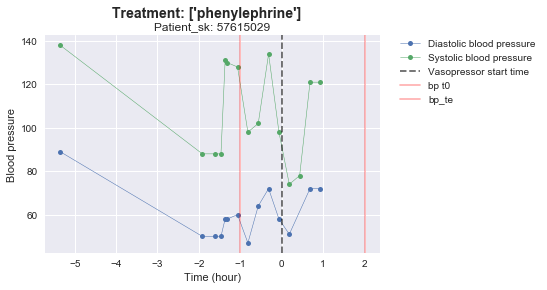

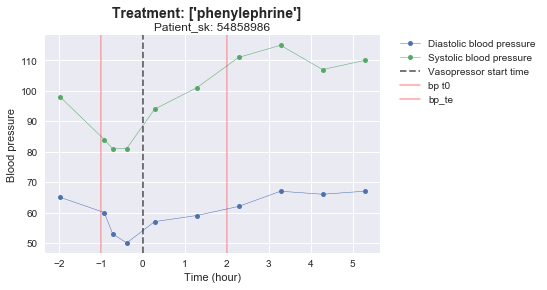

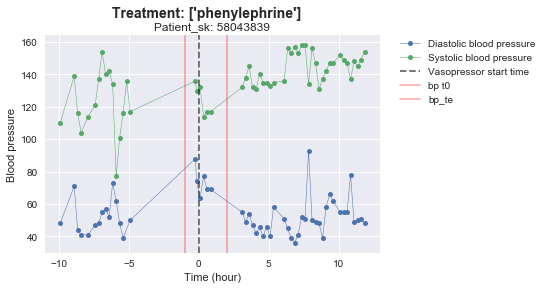

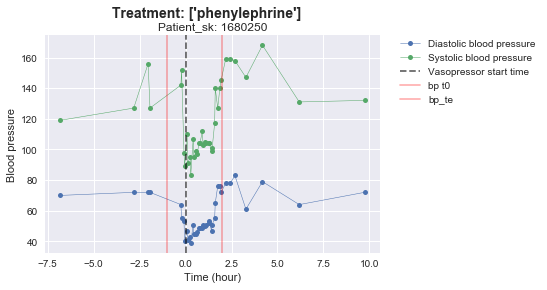

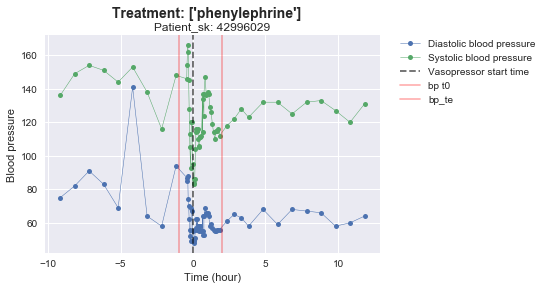

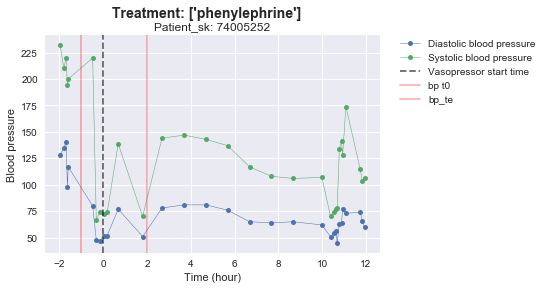

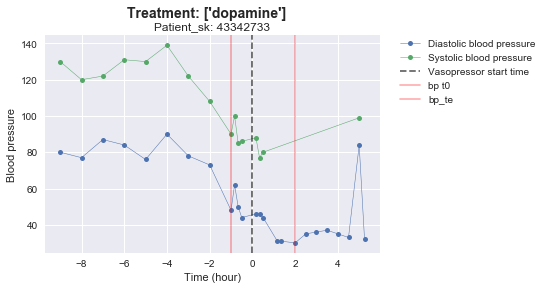

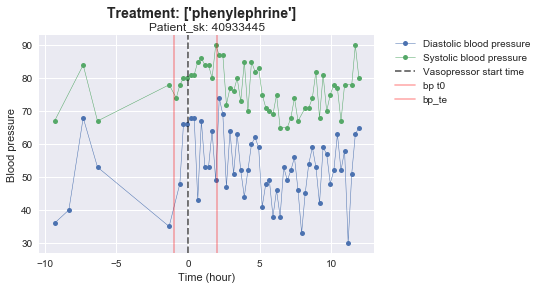

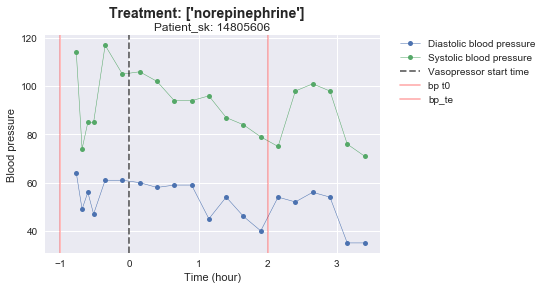

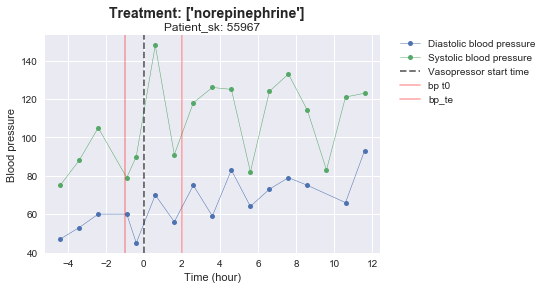

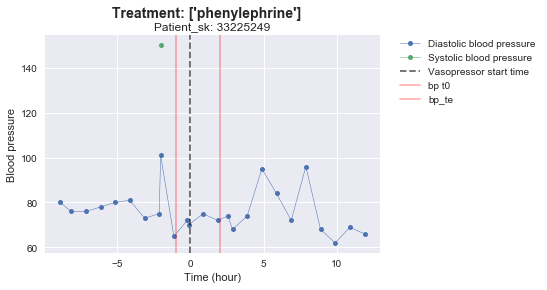

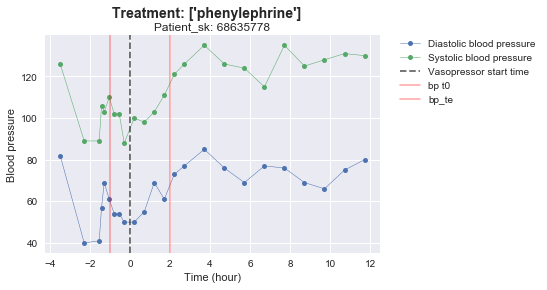

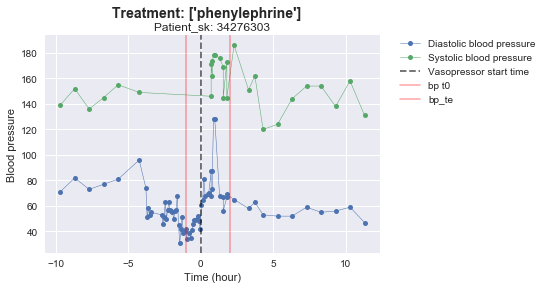

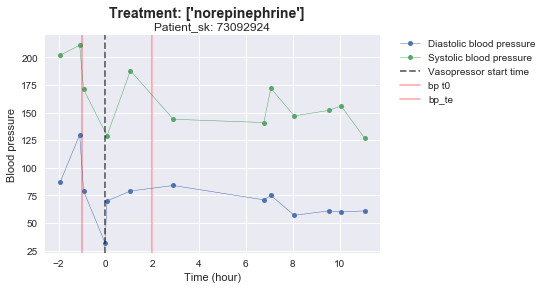

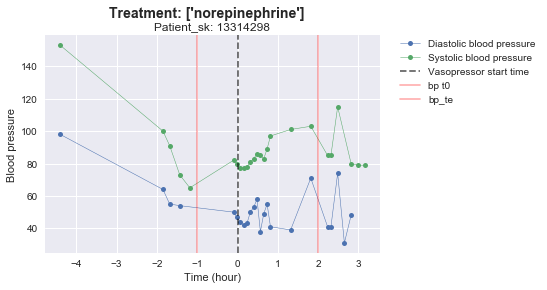

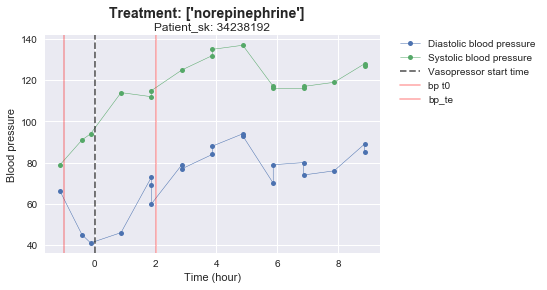

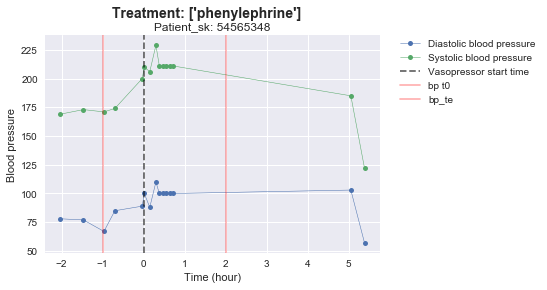

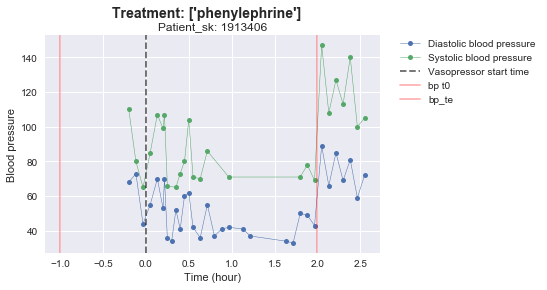

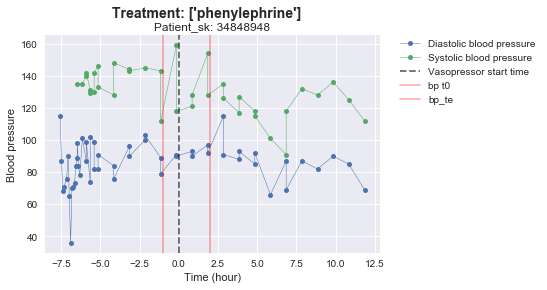

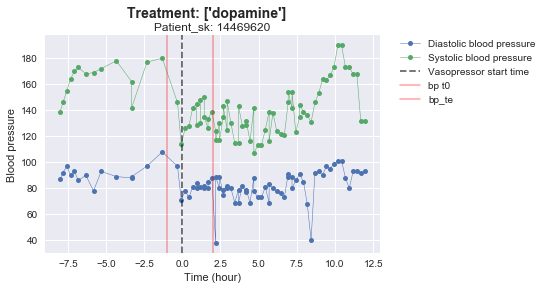

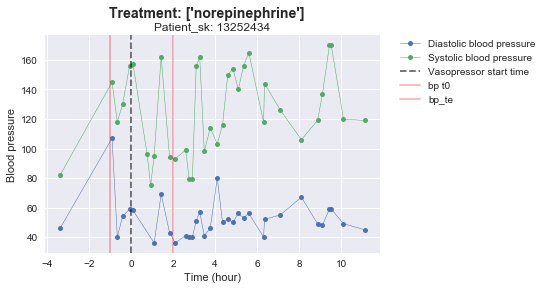

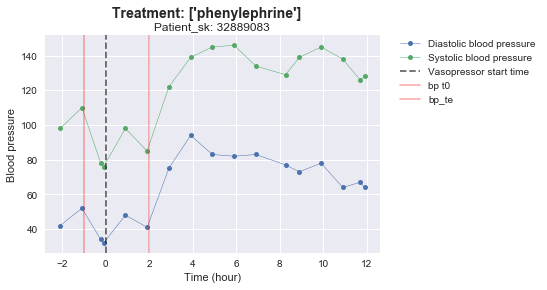

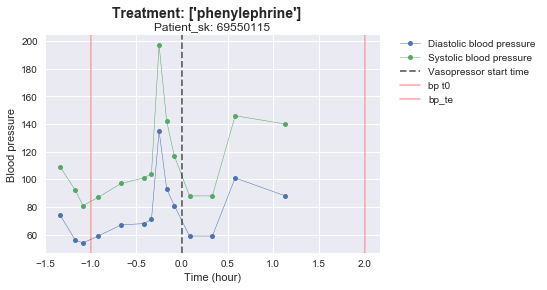

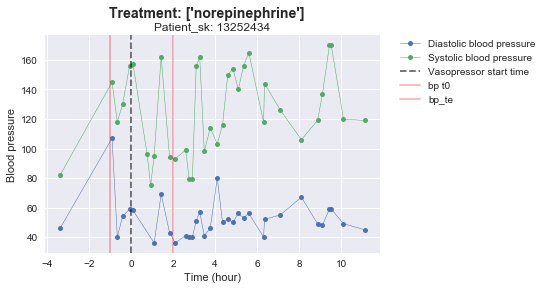

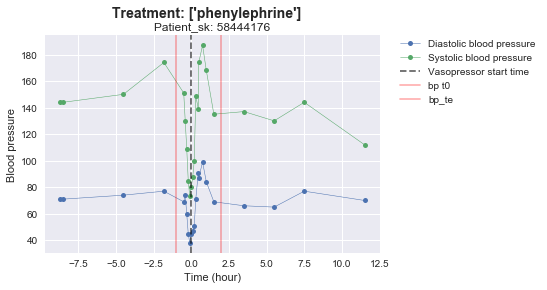

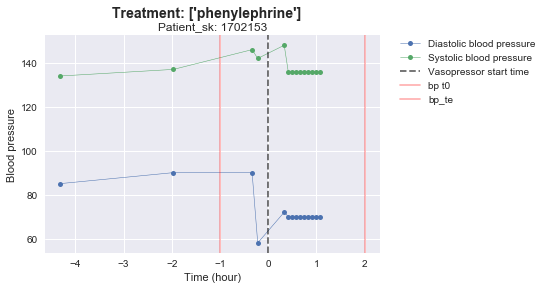

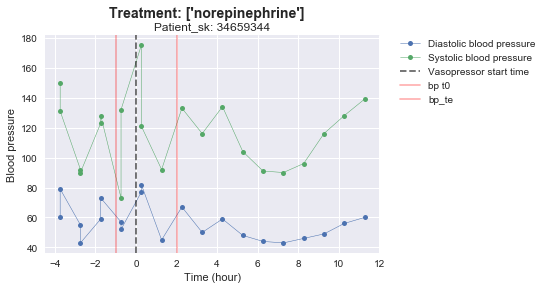

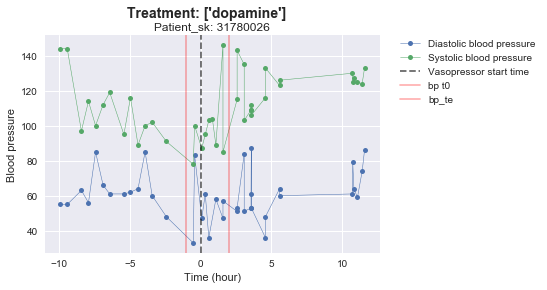

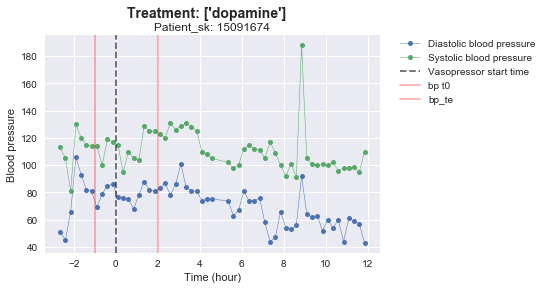

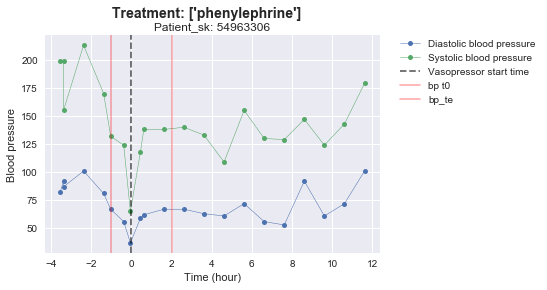

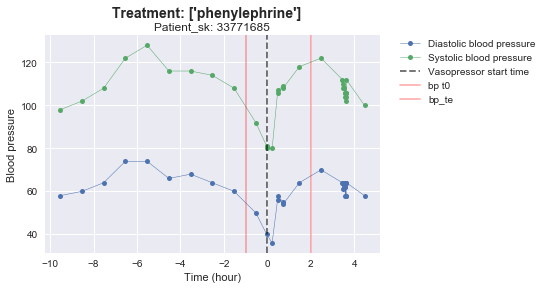

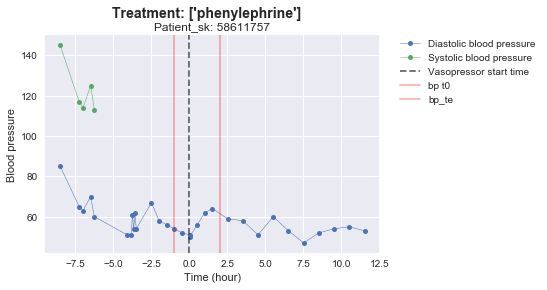

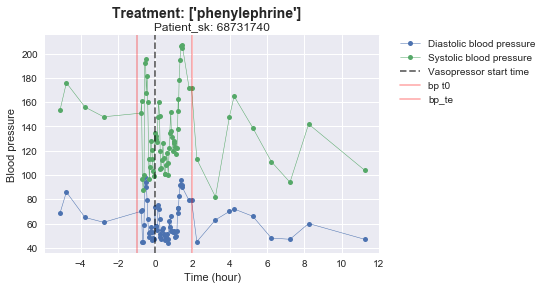

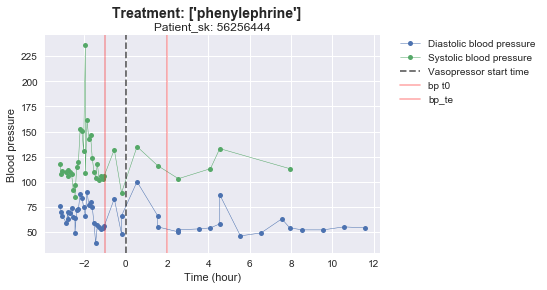

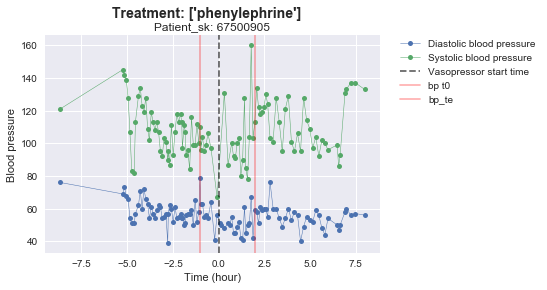

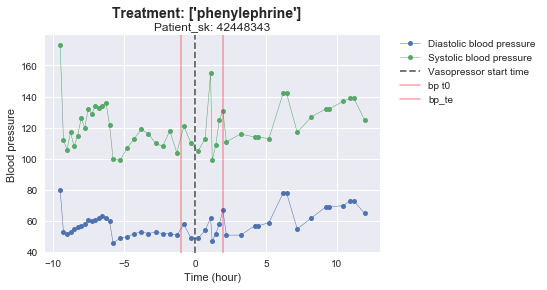

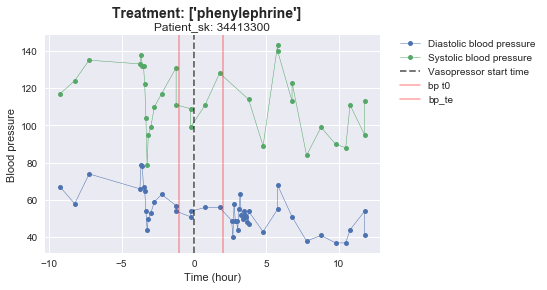

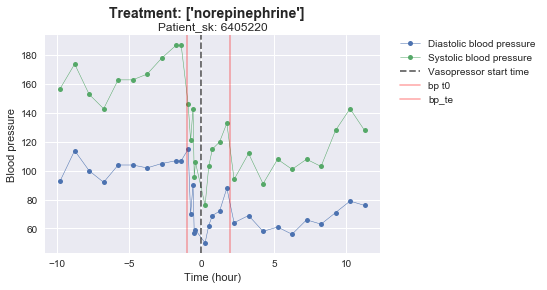

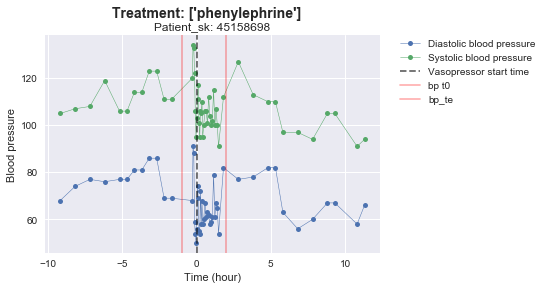

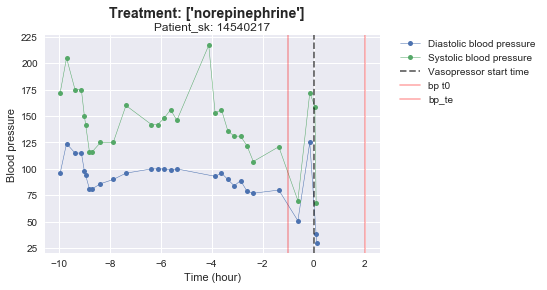

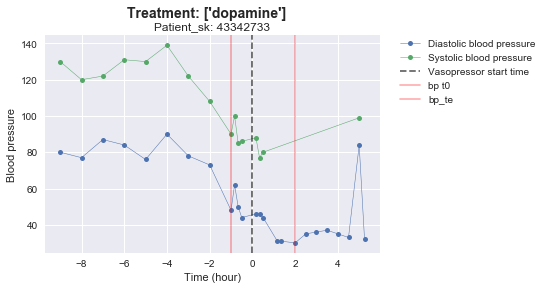

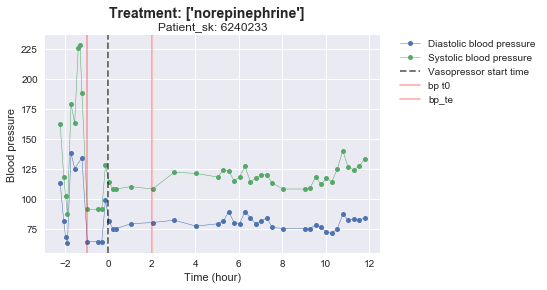

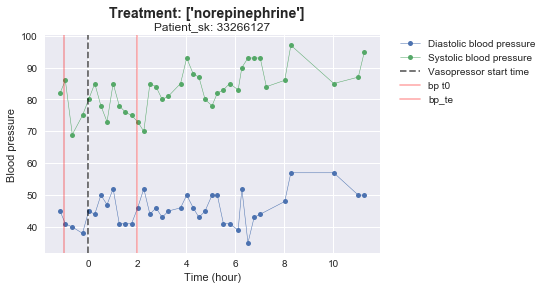

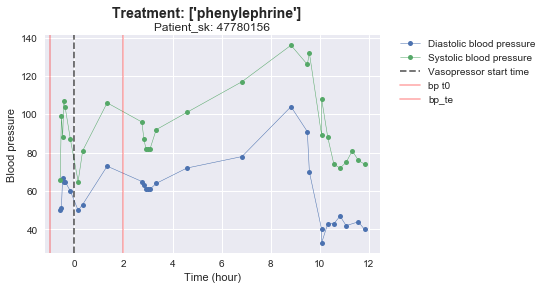

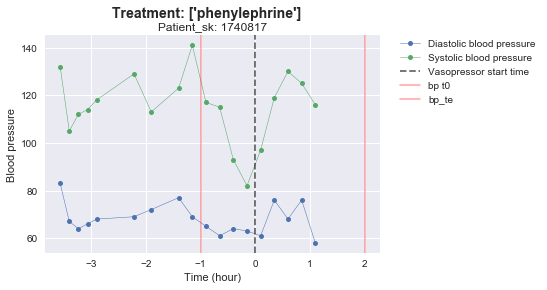

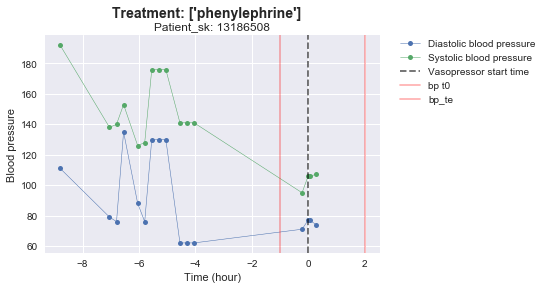

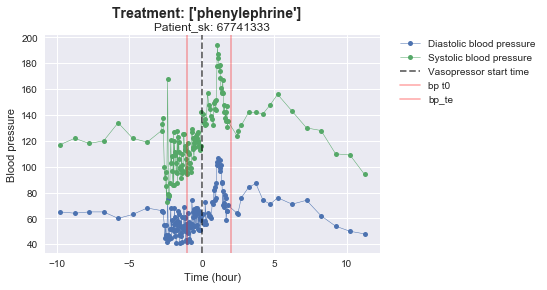

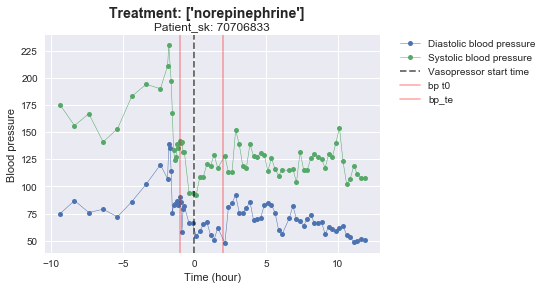

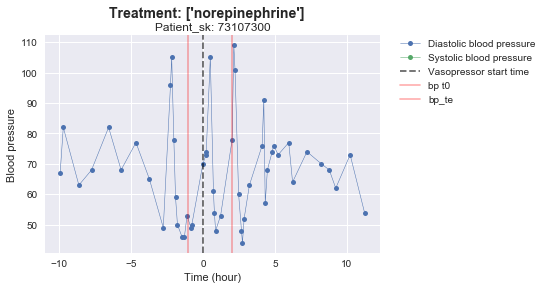

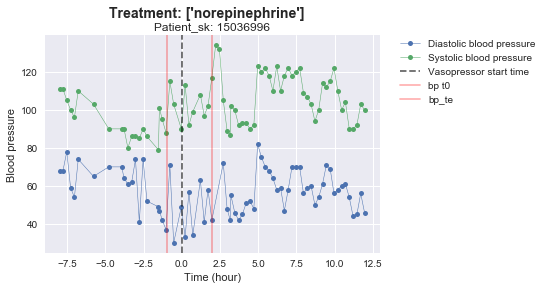

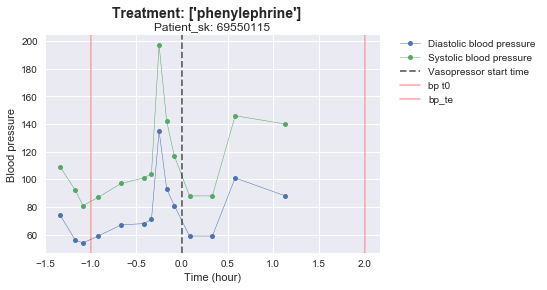

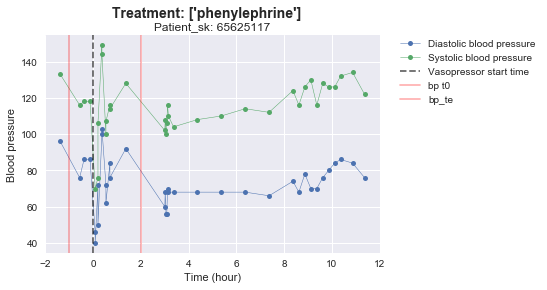

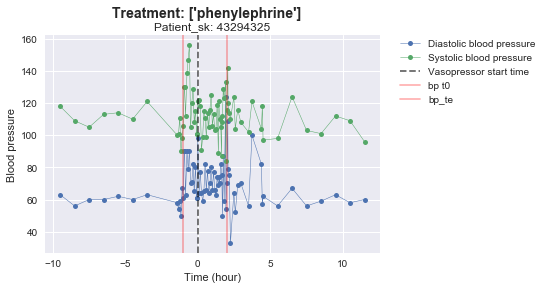

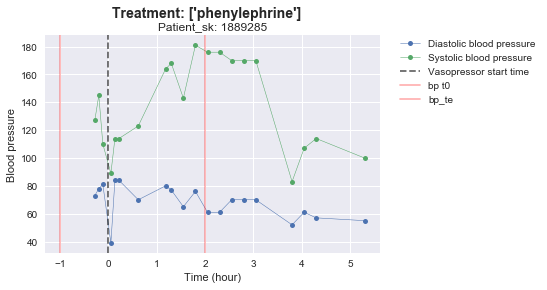

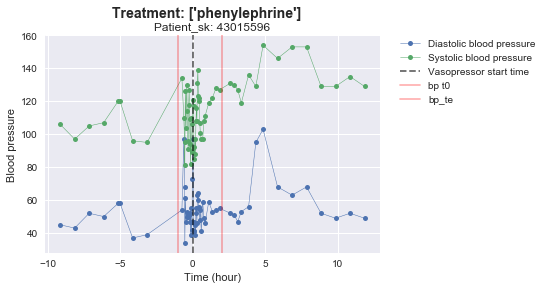

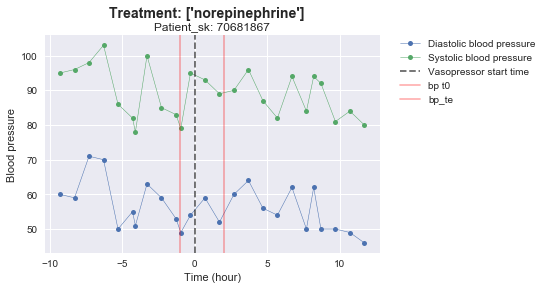

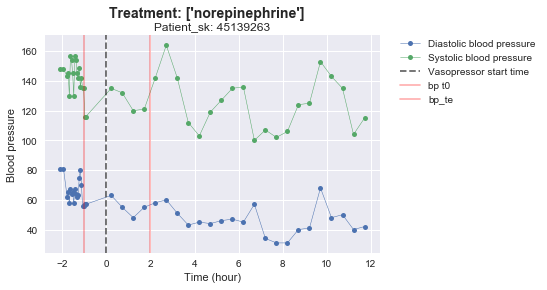

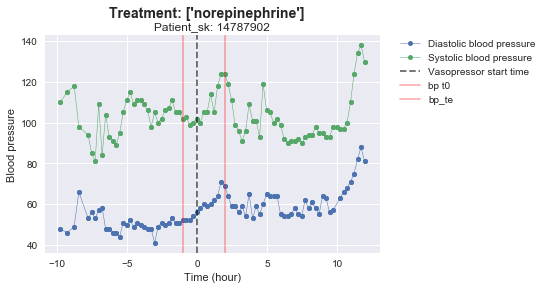

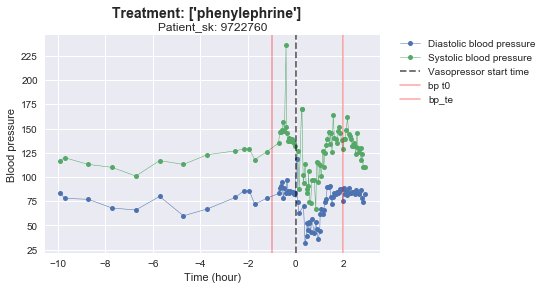

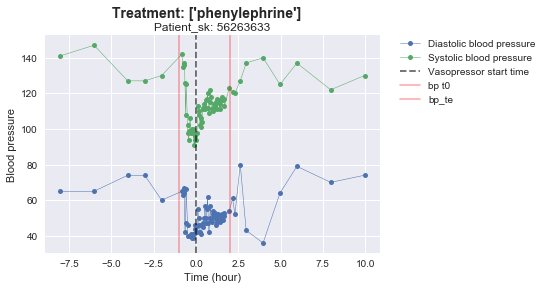

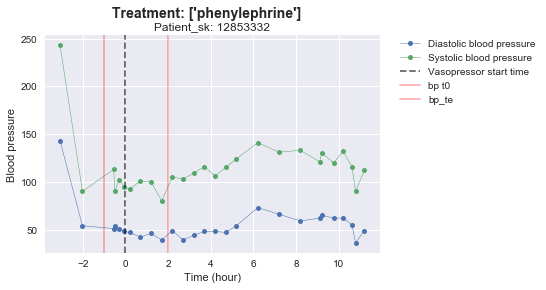

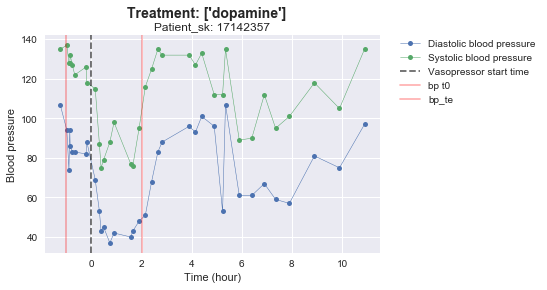

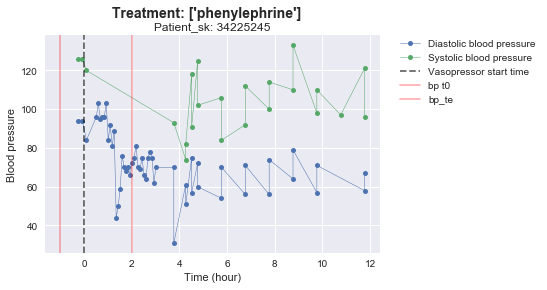

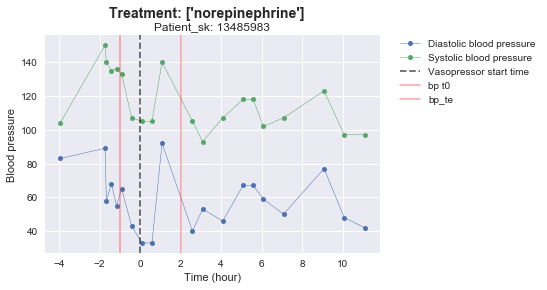

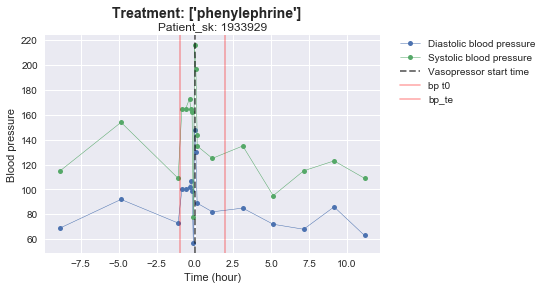

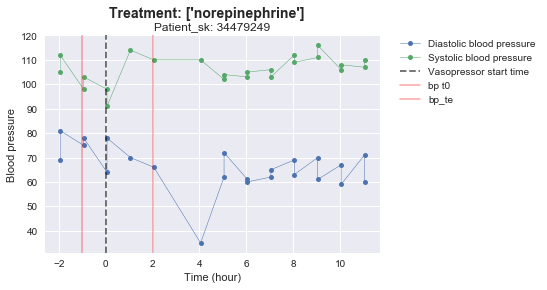

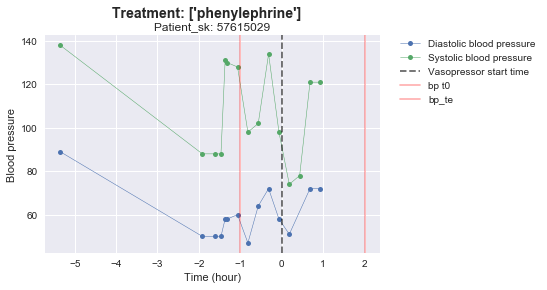

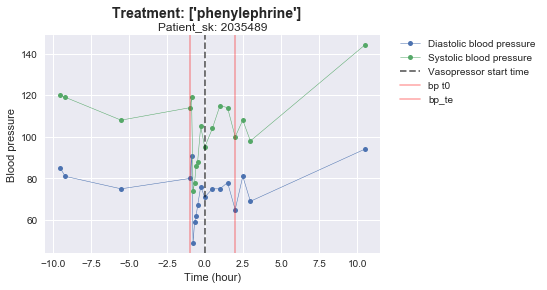

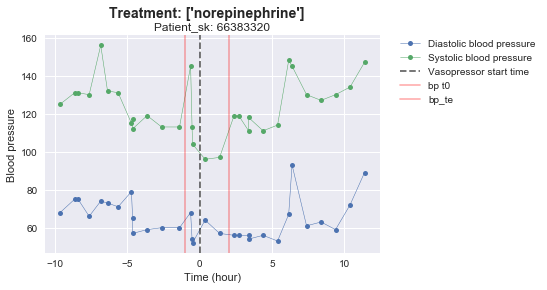

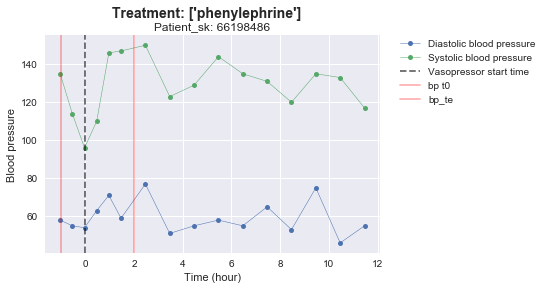

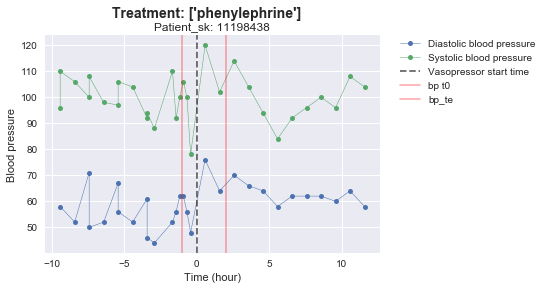

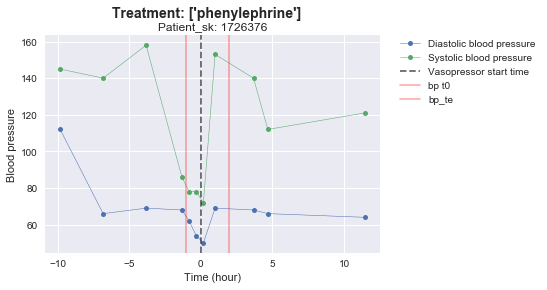

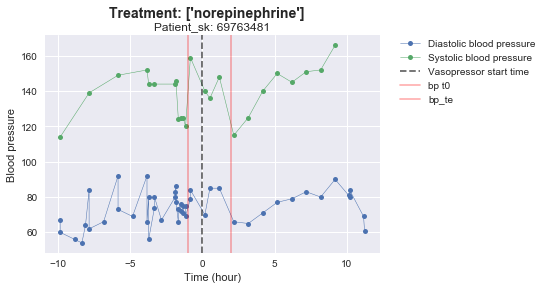

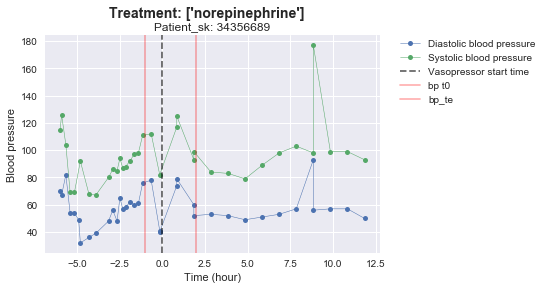

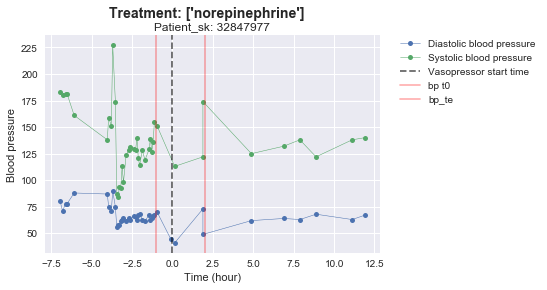

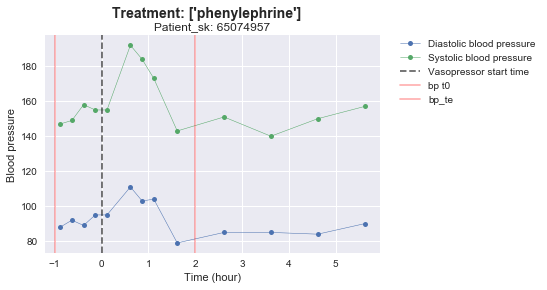

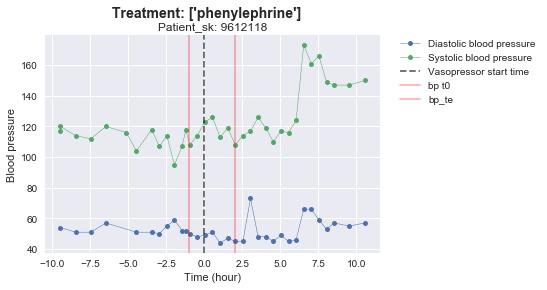

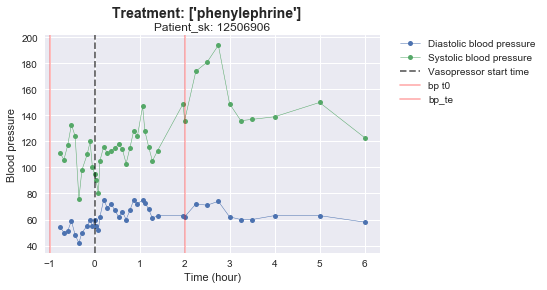

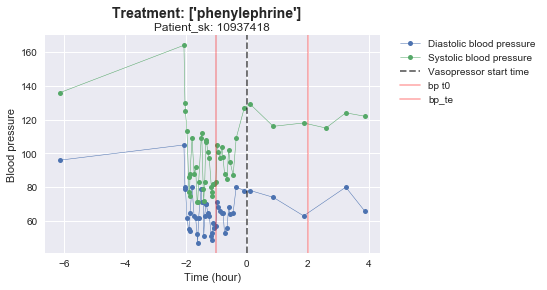

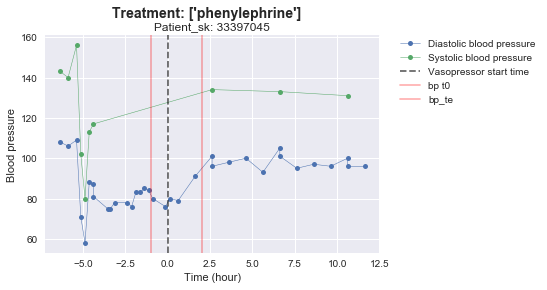

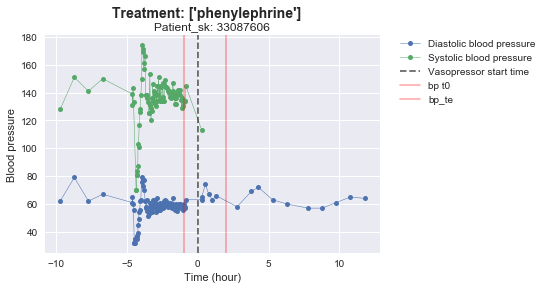

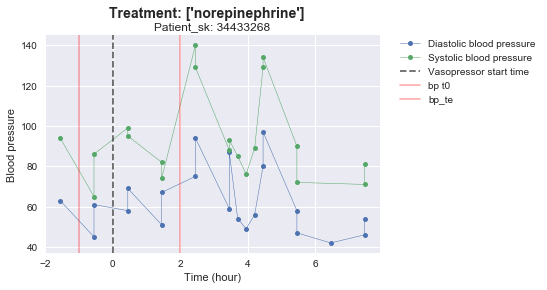

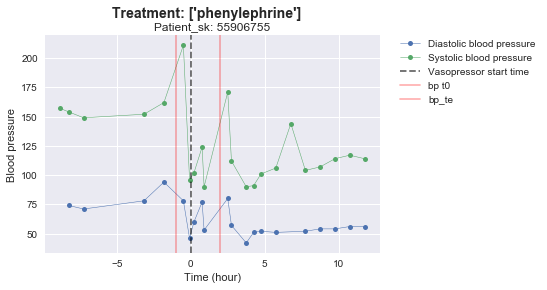

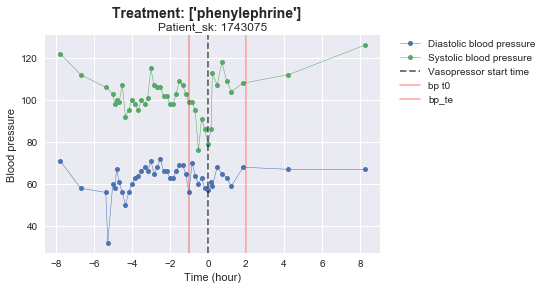

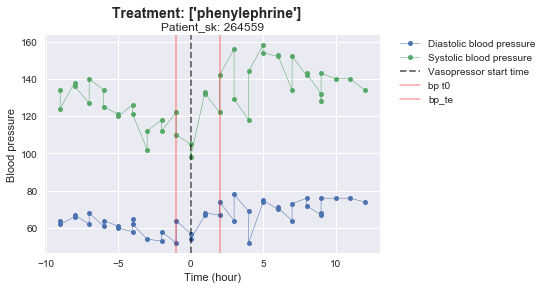

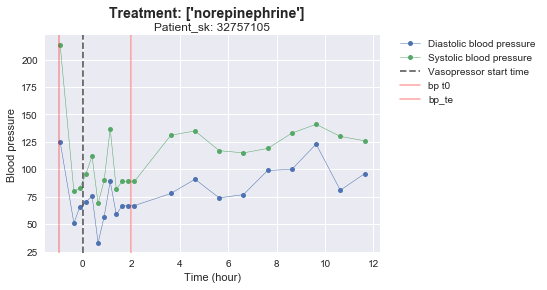

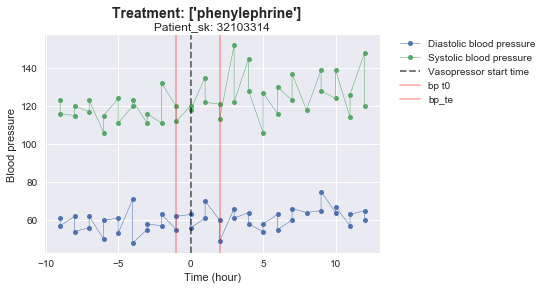

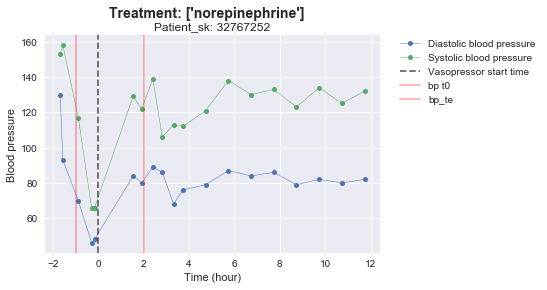

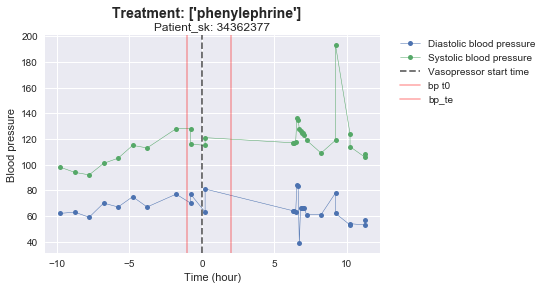

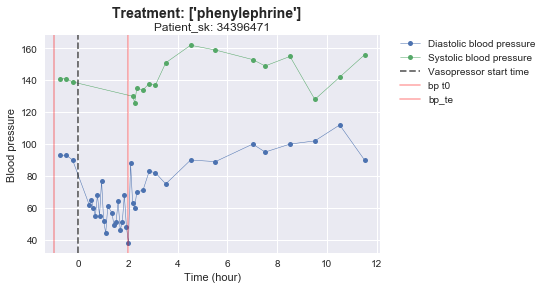

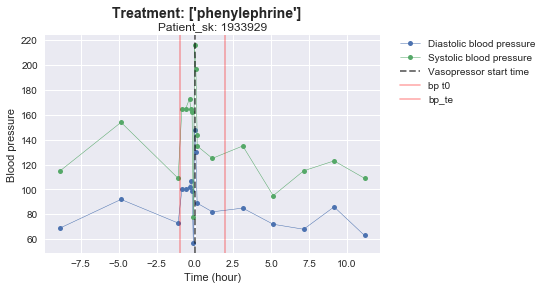

In [5]:
# Plot the figure
sample_patient_sk = np.random.choice(valid_pat_sk, 100)
# In order to visualize the total consumed strength, we specify the linewidth
# of vertical line by normalizing total consumed strength
for patient_sk in sample_patient_sk:
    sample_diasbp = Diastolic_BP[Diastolic_BP['PATIENT_SK'] == patient_sk]
    sample_sysbp = Systolic_BP[Systolic_BP['PATIENT_SK'] == patient_sk]
    sample_med = pat_firsttreat[
        pat_firsttreat['PATIENT_SK'] == patient_sk]
    # Convert the time as the time difference from the first event time
    time_diasbp = sample_diasbp['EVENT_DATE'] - sample_med[
            'MED_STARTED_DT_TM'].iloc[0]
    time_sysbp = sample_sysbp['EVENT_DATE'] - sample_med[
            'MED_STARTED_DT_TM'].iloc[0]
    vaso_start = sample_med['MED_STARTED_DT_TM'] - sample_med[
            'MED_STARTED_DT_TM'].iloc[0]
    # Convert the resolution of time from second to hour
    time_diasbp = time_diasbp.apply(total_hours)
    time_sysbp = time_sysbp.apply(total_hours)
    vaso_start = vaso_start.apply(total_hours)
    bp_te = vaso_start+vaso_window
    bp_t0 = vaso_start-bp_t0_window
    # We care more about the time interval near the interval bewteen the startted
    # time and stopped time
    bp_threshold = 10
    time_interval_interested = [vaso_start.iloc[0]-bp_threshold,
                                bp_te.iloc[-1]+bp_threshold]
    time_interested_dias = pd.cut(time_diasbp, time_interval_interested)
    diasbp_interested = sample_diasbp[time_interested_dias.notnull()][
            'RESULT_VALUE_NUM']
    time_diasbp = time_diasbp[time_interested_dias.notnull()]
    time_interested_sys = pd.cut(time_sysbp, time_interval_interested)
    sysbp_interested = sample_sysbp[time_interested_sys.notnull()][
            'RESULT_VALUE_NUM']
    time_sysbp = time_sysbp[time_interested_sys.notnull()]
    
    fig, ax = plt.subplots()
    ax.plot(time_diasbp, diasbp_interested, "-o", markersize=5,
            linewidth=0.5, label="Diastolic blood pressure")
    ax.plot(time_sysbp, sysbp_interested, "-o", markersize=5,
            linewidth=0.5, label='Systolic blood pressure')
    ax.axvline(x=vaso_start.iloc[0], alpha=0.6, color="black", linestyle='--',
                       label='Vasopressor start time')
    ax.axvline(x=bp_t0.iloc[0], alpha=0.3, color="red",
                       label='bp t0')
    ax.axvline(x=bp_te.iloc[0], alpha=0.3, color="red",
                       label='bp_te')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    fig.suptitle('Treatment: {}'.format(sample_med['GENERIC_NAME'].unique()),
                 fontsize=14, fontweight='bold')
    ax.set_title('Patient_sk: {}'.format(patient_sk))
    ax.set_xlabel('Time (hour)')
    ax.set_ylabel('Blood pressure')